In [419]:
# Imports
import torch
from torch import nn

import torchmetrics

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

In [420]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Food Vision Mini
---
This is a small version of a food-classfication project which classifies an image as pizza, steak or sushi.

The data used for this project is from Food-101 dataset which contains 101 different food classes with 1000 images per class including both trianing and testing.

Our dataset contains only 3 different classes (pizza, steak, sushi) and only 10% of the images.

## Data Download

In [421]:
# Downloading the data -> pizza, steak, sushi
import requests
from pathlib import Path
import zipfile

data_path = Path('./data/')

# Check if the folder already exists
if data_path.is_dir():
    print(f"Data has already been downloaded.")
else:
    data_path.mkdir(parents=True, exist_ok=True)
    
    print("Downloading data...\n\n")
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
        f.write(request.content)
    
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(data_path)
    
    print("Download successful.")

Data has already been downloaded.


## Data Preperation and Exploration

In [422]:
# Walkthrough the data folder
import os

def walk_through_dir(dir_path):
    """
    The function goes through all the directories and files of the given root directory.
    It prints the number of directories and files that are in a directory starting at the root until the deepest dir.
    
    Args:
        dir_path: A Path file which contains the path for the root directory.
        
    Returns:
        None
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} in {dirpath}")

In [423]:
walk_through_dir(data_path)

There are 2 directories and 1 in data
There are 3 directories and 0 in data/test
There are 0 directories and 19 in data/test/steak
There are 0 directories and 25 in data/test/pizza
There are 0 directories and 31 in data/test/sushi
There are 3 directories and 0 in data/train
There are 0 directories and 75 in data/train/steak
There are 0 directories and 78 in data/train/pizza
There are 0 directories and 72 in data/train/sushi


### Data Class Summary

- Pizza: 78 Train / 25 Test

- Steak: 75 Train / 19 Test

- Sushi: 72 Train / 31 Test

## Random Visualization

In [424]:
# Random data visualization
import random

# list of all the paths of the images in the data folder
image_paths = list(data_path.glob('*/*/*.jpg'))

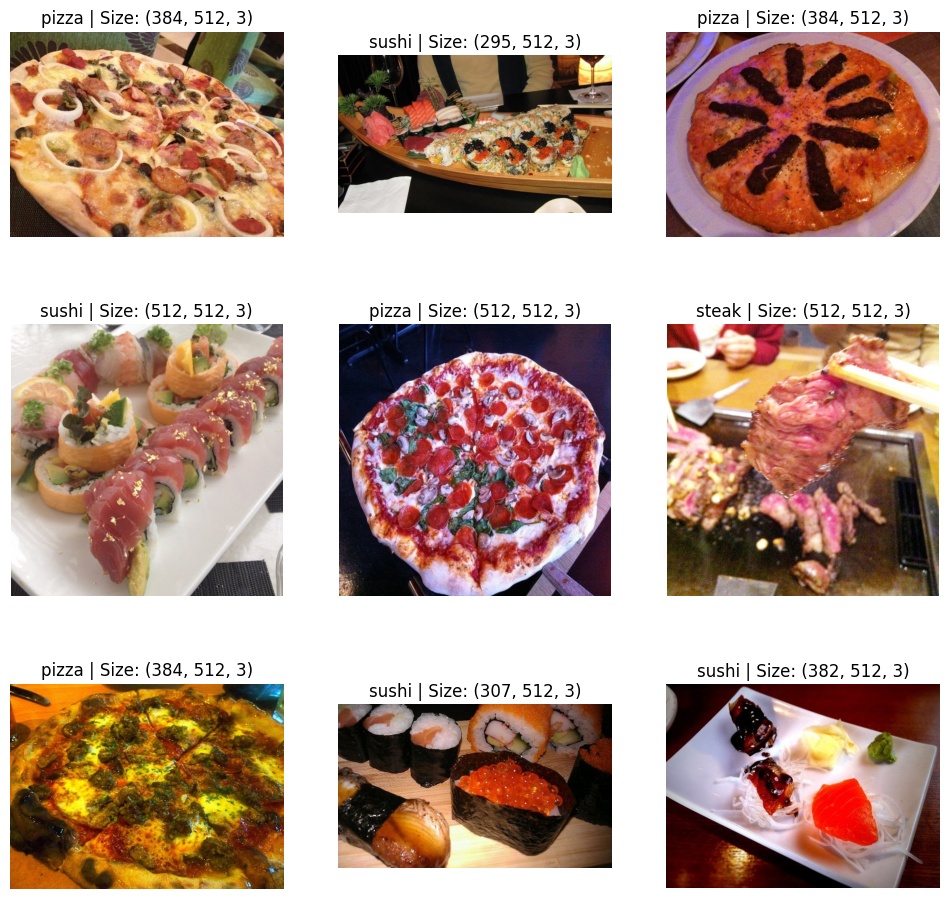

In [425]:
# Random images using matplotlib
fig = plt.figure(figsize = (12, 12))
rows, cols = 3, 3

random_image_paths = random.choices(image_paths, k=rows*cols)

for i, path in enumerate(random_image_paths):
    img = Image.open(path)
    img = np.asarray(img)
    
    fig.add_subplot(rows, cols, i+1)
    
    plt.imshow(img)
    plt.title(f"{str(path.parent.stem)} | Size: {img.shape}")
    plt.axis(False)

## Transformations

In [426]:
train_data_transform = transforms.Compose([
    # Resize
    transforms.Resize(size = (64, 64)),
    # Flip
    transforms.RandomHorizontalFlip(p = 0.5),   # probability = 50%
    # Image to tensor
    transforms.ToTensor(),
])

test_data_transform = transforms.Compose([
    # Resize
    transforms.Resize(size = (64, 64)),
    # Image to tensor
    transforms.ToTensor(),
])

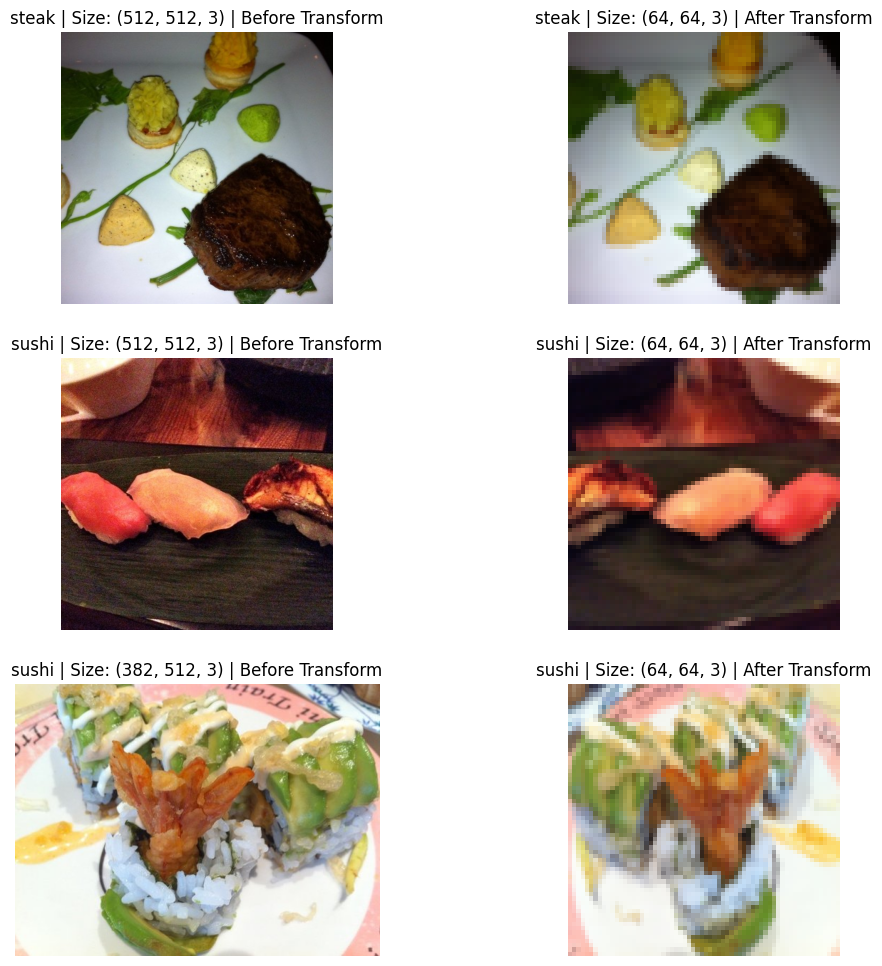

In [427]:
# Compare random images using matplotlib before and after transform
fig = plt.figure(figsize = (12, 12))
rows, cols = 3, 2
subplot_num = 0

random_image_paths = random.choices(image_paths, k=int((rows*cols)/2))

for i, path in enumerate(random_image_paths):
    img = Image.open(path)
    
    img_no_transform = np.asarray(img)
    img_transform = np.asarray(train_data_transform(img).permute(1,2,0))
    
    subplot_num += 1
    fig.add_subplot(rows, cols, subplot_num)
    plt.imshow(img_no_transform)
    plt.title(f"{str(path.parent.stem)} | Size: {img_no_transform.shape} | Before Transform")
    plt.axis(False)
    
    subplot_num += 1
    fig.add_subplot(rows, cols, subplot_num)
    plt.imshow(img_transform)
    plt.title(f"{str(path.parent.stem)} | Size: {img_transform.shape} | After Transform")
    plt.axis(False)

### Data discrepency notes:

- Image shapes vary (Random image visualization)
    - Dealt with the issue using Resize() transform

- There are mismatches between pictures and labels. <br>
eg: A picture of a cup labeled as pizza, fries as pizza (Random image visualization)

## Loading image data using ImageFolder

In [428]:
# Setting train and test directories
train_dir = data_path / 'train'
test_dir = data_path / 'test'

In [429]:
# Loading the datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_data_transform,
                                  target_transform=None)            # No transformation for labels

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_data_transform,
                                 target_transform=None)

print(train_data)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [430]:
# Loading datasets to dataloaders
batch_size = 16

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=4,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size * 2,
                             num_workers=4,
                             shuffle=True)

In [431]:
# Creating variables for class information
class_names = train_data.classes
class_names_dict = train_data.class_to_idx

print(class_names)
print()
print(class_names_dict)

['pizza', 'steak', 'sushi']

{'pizza': 0, 'steak': 1, 'sushi': 2}


## Loading images using a custom `Dataset` class

When: <br>
    <ul> - To be used when the `data` has a custom structure.</ul>
    <ul> - More flexibility.</ul>

What: <br>
    <ul> - A custom class to extract data from the `data` folder.</ul>

In [432]:
# Necessary imports
import os
from typing import Tuple, Dict, List

In [433]:
# Creating a function to find classes within the data directory
def find_classes(directory: Path) -> Tuple[List[str], Dict[str, int]]:
    """
    A function that returns a list of class names and a dictionary of class names and its indices /
    given a directory with data.
    
    Args:
        directory: The path of the directory with the class names. It can be both a 'str' or a 'Path' object.
        
    Returns: 
        A tuple with - [List of class names] and {Dictionary with class names and its indices}.
    
    Raises:
        FileNotFoundError when there are no directories found in the given path.
    """
    class_names = sorted([entry.name for entry in os.scandir(directory)])
    
    if not class_names:
        raise FileNotFoundError("No directories found in the given path. Please check the structure.")
    
    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
    
    return class_names, class_to_idx

Functionality to include:
- Have `paths` which holds all the paths of our data.
- Capable of `transforms` if there is a list of transforms being passed.
- Have a list of class names.
- Have a dictionary with class names and thier class indices.
- Function to open an image called `load_image()`.
- Overwrite both `len` and `getitem` dunder methods. 

In [434]:
# Creating a custom Dataset object replicating ImageFolder
class CustomImageFolder(Dataset):
    def __init__(self,
                 directory: Path,
                 transforms = None) -> None:
        super().__init__()
        
        self.paths = list(directory.glob("*/*.jpg"))
        self.transforms = transforms
        self.classes, self.class_to_idx = find_classes(directory)
        
    def load_image(self, index: int) -> Image.Image:
        """
        To open an image given an index of the datapoint.
        """
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        """
        Return total number of samples in the class instance
        """
        return len(self.paths)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        """
        Returns on datapoint given an index -> (data, label) 
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.stem
        class_index = self.class_to_idx[class_name]
        
        # Transform
        if self.transforms:
            return self.transforms(img), class_index
        else:
            return transforms.functional.pil_to_tensor(img), class_index

In [435]:
# Testing out the custom class
custom_train_data = CustomImageFolder(directory=train_dir,
                                      transforms=train_data_transform)

print(custom_train_data.class_to_idx)
print()
print(custom_train_data.classes)
print()
print(len(custom_train_data))
print()
print(custom_train_data.paths[:2])
print()
print(custom_train_data.__getitem__(1))

{'pizza': 0, 'steak': 1, 'sushi': 2}

['pizza', 'steak', 'sushi']

225

[PosixPath('data/train/steak/167069.jpg'), PosixPath('data/train/steak/1264154.jpg')]

(tensor([[[0.2941, 0.1412, 0.0980,  ..., 0.3098, 0.2706, 0.2431],
         [0.3647, 0.1725, 0.1098,  ..., 0.2824, 0.2275, 0.2000],
         [0.4314, 0.2118, 0.1176,  ..., 0.2431, 0.2118, 0.2353],
         ...,
         [0.2549, 0.2667, 0.2392,  ..., 0.0471, 0.0902, 0.1059],
         [0.2314, 0.2275, 0.2078,  ..., 0.0471, 0.0784, 0.0863],
         [0.1569, 0.1490, 0.1451,  ..., 0.0549, 0.0863, 0.0902]],

        [[0.2314, 0.0510, 0.0314,  ..., 0.1490, 0.1216, 0.1020],
         [0.3098, 0.0824, 0.0314,  ..., 0.1373, 0.0980, 0.0745],
         [0.3882, 0.1176, 0.0314,  ..., 0.1098, 0.0824, 0.1020],
         ...,
         [0.1216, 0.1373, 0.1137,  ..., 0.0235, 0.0392, 0.0392],
         [0.1137, 0.1137, 0.0980,  ..., 0.0235, 0.0314, 0.0392],
         [0.0706, 0.0588, 0.0588,  ..., 0.0275, 0.0353, 0.0392]],

        [[0.1608, 0.0588, 0.

In [436]:
# Turning custom dataset to dataloder
custom_train_dataloader = DataLoader(dataset=custom_train_data,
                                     batch_size=16,
                                     shuffle=True,
                                     num_workers=0)

custom_img, custom_lable = next(iter(custom_train_dataloader))
print(custom_img.shape)

torch.Size([16, 3, 64, 64])


# Data Augmentation

- Artificially adding diversity to training data.
- For images, its applying different transformations from the transforms library.
- This is done to generalize the model making it better with unseen data.
- Ex: rotate, flip, crop and more.
---
- Trivial augment wide.
- Used to train SOTA models by the pytorch team.

In [437]:
# Using trivial augment for our data transforms

train_data_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

test_data_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor(),
])

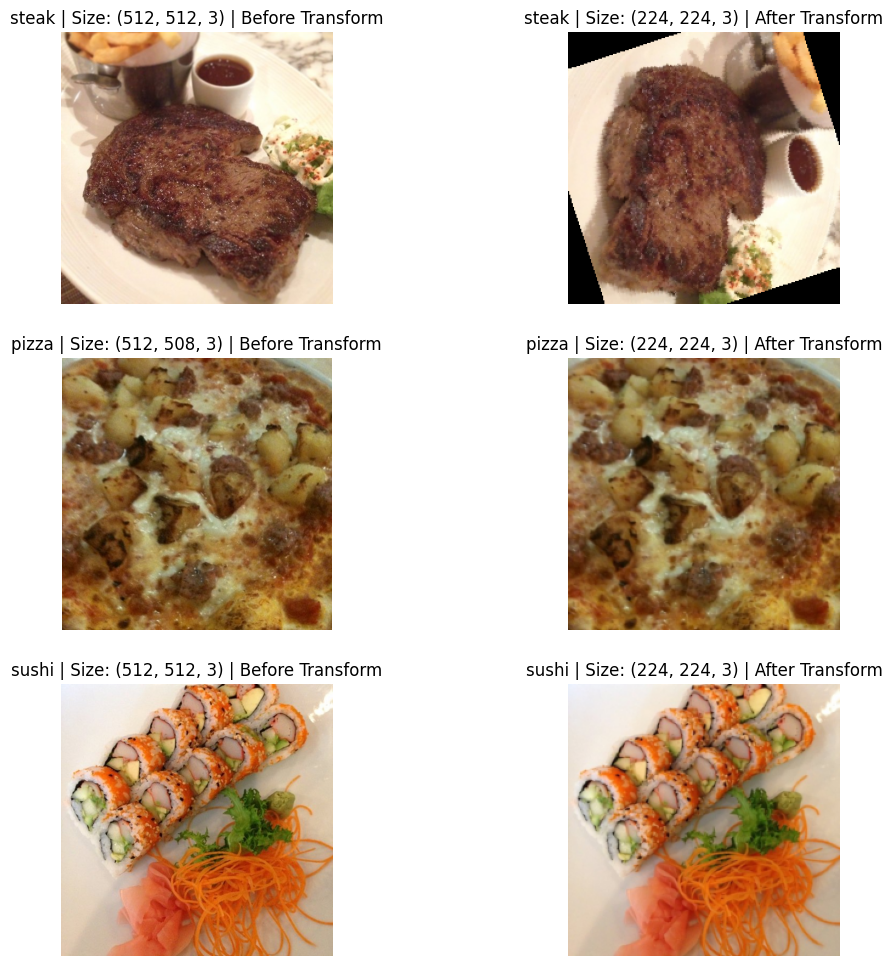

In [438]:
# Compare random images using matplotlib before and after transform
fig = plt.figure(figsize = (12, 12))
rows, cols = 3, 2
subplot_num = 0

random_image_paths = random.choices(image_paths, k=int((rows*cols)/2))

for i, path in enumerate(random_image_paths):
    img = Image.open(path)
    
    img_no_transform = np.asarray(img)
    img_transform = np.asarray(train_data_transform(img).permute(1,2,0))
    
    subplot_num += 1
    fig.add_subplot(rows, cols, subplot_num)
    plt.imshow(img_no_transform)
    plt.title(f"{str(path.parent.stem)} | Size: {img_no_transform.shape} | Before Transform")
    plt.axis(False)
    
    subplot_num += 1
    fig.add_subplot(rows, cols, subplot_num)
    plt.imshow(img_transform)
    plt.title(f"{str(path.parent.stem)} | Size: {img_transform.shape} | After Transform")
    plt.axis(False)

# Model

In [439]:
# Building the model with Tiny VGG architecture
class TinyVGGMiniFoodModel(nn.Module):
    """
    A model with the TinyVGG architecture. Will be used to train a model for image classification.
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16 * 16,
                      out_features=output_shape),
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

In [440]:
# Function with a train loop per epoch
def train_epoch(model: nn.Module,
                dataloader: DataLoader,
                loss_function: nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> Dict:
    """
    This function goes through the entire dataloader and performs a gradient descent for every batch.
    
    Args:
        model: The model to be trained. Subclasses torch.nn.Module class.
        dataloader: A dataloader that contains the training dataset as a DataLoader object.
        loss_function: A function to calculate the loss and perform backward pass.
        optimizer: An optmizer to perform gradient descent.
        device: Device of choice for computations.
    
    Returns:
        Returns a dictionary object which contains: 
            - Average training loss for the entire epoch.
    """
    # Set model to train mode
    model.train()
    
    # Variable to trace loss
    train_loss = 0
    
    # Move model to device
    model = model.to(device)
    
    for batch, (X, y) in enumerate(dataloader):
        # Move data to device
        X = X.to(device)
        y = y.to(device)
        
        # Forward Pass -> Loss -> Zero Grad ->  Back Propagation -> Gradient Descent
        y_preds = model(X)
        loss = loss_function(y_preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate training loss
        train_loss += loss
    
        # Print out batch number and loss
        if batch % int(len(dataloader)/4):
            print(f"Batch: {batch}  |  Loss: {loss}")
    
    train_loss /= len(dataloader)
    return {"train_loss": train_loss.item()}

In [441]:
# Function with test loop per epoch
def test_epoch(model: nn.Module,
               dataloader: DataLoader,
               loss_function: nn.Module,
               accuracy_function: torchmetrics.Accuracy,
               device: torch.device) -> Dict:
    """
    This function goes through the entire dataloader and tests the model.
    
    Args:
        model: The model to be tested. Subclasses torch.nn.Module class.
        dataloader: A dataloader that contains the testing dataset as a DataLoader object.
        loss_function: A function to calculate the loss.
        accuracy_function: Funciton to calculate accuracy.
        device: Device of choice for computations.
    
    Returns:
        Returns a dictionary object which contains: 
            - Average testing loss for the entire epoch.
            - Average testing accuracy for the entire epoch.
    """
    # Set the model to eval mode
    model.eval()
    
    # Variables to track loss and accuracy
    test_loss = 0
    test_accuracy = 0
    
    # Model and accuracy function to device
    model = model.to(device)
    accuracy_function = accuracy_function.to(device)
    
    for X, y in dataloader:
        # Data to device
        X = X.to(device)
        y = y.to(device)
        
        # Forward pass, loss and accuracy
        y_pred = model(X)
        test_loss += loss_function(y_pred, y)
        test_accuracy += accuracy_function(torch.argmax(y_pred, dim = 1).squeeze(), y)
    
    # Average
    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)
    return {'test_loss': test_loss.item(),
            'test_accuracy': test_accuracy.item()}

In [442]:
# Function for a training loop given an epoch
from tqdm.auto import tqdm

def train_loop(epochs: int,
                model: nn.Module,
                train_dataloader: DataLoader,
                test_dataloader: DataLoader,
                loss_function: nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_function: torchmetrics.Accuracy,
                device: torch.device) -> Dict:
    """
    A function to train the given model on training data while performing testing with testing data for
    every epoch. 
    
    Args:
        epochs: Number of epochs the model goes through while training.
        model: The model to be tested. Subclasses torch.nn.Module class.
        train_dataloader: A dataloader that contains the training dataset as a DataLoader object.
        test_dataloader: A dataloader that contains the testing dataset as a DataLoader object.
        loss_function: A function to calculate the loss.
        optimizer: An optmizer to perform gradient descent.
        accuracy_function: Funciton to calculate accuracy.
        device: Device of choice for computations.
    
    Returns:
        Returns a dictionary object which contains: 
            - A list of training loss which was tracked during training.
            - A list of testing loss which was tracked during training.
            - A list of testing accuracy which was tracked during training.
    """
    results = {
        'train_loss': [],
        'test_loss': [],
        'test_accuracy': []
    }
    
    # Run through every epoch
    for epoch in tqdm(range(epochs)):
        print(f"\nEPOCH: {epoch} ----------------------------------------------- \n")
        train_dict = train_epoch(model = model,
                                    dataloader=train_dataloader,
                                    loss_function=loss_function,
                                    optimizer=optimizer,
                                    device=device)
        test_dict = test_epoch(model=model,
                                  dataloader=test_dataloader,
                                  loss_function=loss_function,
                                  accuracy_function=accuracy_function,
                                  device=device)
    
        print(f"Epoch: {epoch}  |  Loss: {train_dict['train_loss']:.2f}  |  Test Loss: {test_dict['test_loss']:.2f}  |  Test Accuracy: {test_dict['test_accuracy']:.2f}")
        
        results['train_loss'].append(train_dict['train_loss'])
        results['test_loss'].append(test_dict['test_loss'])
        results['test_accuracy'].append(test_dict['test_accuracy'])
    
    return results

In [454]:
# Function to plot loss curves
def plot_loss_curves(results: Dict[str, List[float]]) -> None:
    """
    A function to plot the loss curves given a dictionary with the relevant results.
    
    Args:
        results: A dictionary item which contains keys as - 'train_loss', 'test_loss' - and a list of 
            corresponding values for each epoch.
    
    Returns:
        None
    """
    # Get loss lists
    train_loss = results['train_loss']
    test_loss = results['test_loss']
    
    epochs = range(len(results['train_loss']))
    
    plt.figure(figsize = (6,4))
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

### Training the model with NO data augmentation

In [444]:
# A simple transform for the data
simple_data_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [445]:
# Load and apply transforms
simple_train_data = datasets.ImageFolder(root=train_dir,
                                         transform=simple_data_transform)

simple_test_data = datasets.ImageFolder(root=test_dir,
                                        transform=simple_data_transform)

In [446]:
# Turn to DataLoaders
batch_size = 32
num_workers = 4

simple_train_dataloader = DataLoader(dataset=simple_train_data,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     num_workers=num_workers)

simple_test_dataloader = DataLoader(dataset=simple_test_data,
                                    batch_size=batch_size * 2,
                                    shuffle=True,
                                    num_workers=num_workers)

In [447]:
# Instantiaing the model
from torchinfo import summary

model_no_augment = TinyVGGMiniFoodModel(input_shape=3,
                                        hidden_units=20,
                                        output_shape=len(class_names)).to(device)

summary(model_no_augment, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGMiniFoodModel                     [1, 3]                    --
├─Sequential: 1-1                        [1, 20, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 20, 64, 64]           560
│    └─ReLU: 2-2                         [1, 20, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 20, 64, 64]           3,620
│    └─ReLU: 2-4                         [1, 20, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 20, 32, 32]           --
├─Sequential: 1-2                        [1, 20, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 20, 32, 32]           3,620
│    └─ReLU: 2-7                         [1, 20, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 20, 32, 32]           3,620
│    └─ReLU: 2-9                         [1, 20, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 20, 16, 16]           --
├─Seq

In [448]:
# Loss function, optimizer, accuracy function
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_no_augment.parameters(),
                             lr = 0.002)
accuracy_function = torchmetrics.Accuracy(task='multiclass', num_classes=3)

In [449]:
# Training the model
results_no_augment = train_loop(epochs = 25,
                                model=model_no_augment,
                                train_dataloader=simple_train_dataloader,
                                test_dataloader=simple_test_dataloader,
                                loss_function=loss_function,
                                optimizer=optimizer,
                                accuracy_function=accuracy_function,
                                device=device)

  0%|          | 0/25 [00:00<?, ?it/s]


EPOCH: 0 ----------------------------------------------- 

Batch: 1  |  Loss: 1.174977421760559
Batch: 3  |  Loss: 1.0780181884765625
Batch: 5  |  Loss: 1.122857928276062
Batch: 7  |  Loss: 1.151212453842163


  4%|▍         | 1/25 [00:00<00:19,  1.24it/s]

Epoch: 0  |  Loss: 1.11  |  Test Loss: 1.10  |  Test Accuracy: 0.32

EPOCH: 1 ----------------------------------------------- 

Batch: 1  |  Loss: 1.0956722497940063
Batch: 3  |  Loss: 1.1032320261001587
Batch: 5  |  Loss: 1.1069719791412354
Batch: 7  |  Loss: 1.1301676034927368


  8%|▊         | 2/25 [00:01<00:15,  1.47it/s]

Epoch: 1  |  Loss: 1.10  |  Test Loss: 1.09  |  Test Accuracy: 0.38

EPOCH: 2 ----------------------------------------------- 

Batch: 1  |  Loss: 1.1031898260116577
Batch: 3  |  Loss: 1.0789884328842163
Batch: 5  |  Loss: 1.0652860403060913
Batch: 7  |  Loss: 1.0537232160568237


 12%|█▏        | 3/25 [00:01<00:13,  1.59it/s]

Epoch: 2  |  Loss: 1.08  |  Test Loss: 1.07  |  Test Accuracy: 0.47

EPOCH: 3 ----------------------------------------------- 

Batch: 1  |  Loss: 1.0243747234344482
Batch: 3  |  Loss: 0.9000350832939148
Batch: 5  |  Loss: 0.8765646815299988
Batch: 7  |  Loss: 0.5561150312423706


 16%|█▌        | 4/25 [00:02<00:12,  1.64it/s]

Epoch: 3  |  Loss: 0.92  |  Test Loss: 1.68  |  Test Accuracy: 0.31

EPOCH: 4 ----------------------------------------------- 

Batch: 1  |  Loss: 1.3663218021392822
Batch: 3  |  Loss: 0.9155125617980957
Batch: 5  |  Loss: 0.8759020566940308
Batch: 7  |  Loss: 1.2429205179214478


 20%|██        | 5/25 [00:03<00:11,  1.71it/s]

Epoch: 4  |  Loss: 1.05  |  Test Loss: 1.12  |  Test Accuracy: 0.33

EPOCH: 5 ----------------------------------------------- 

Batch: 1  |  Loss: 0.918724775314331
Batch: 3  |  Loss: 0.9236618280410767
Batch: 5  |  Loss: 0.9410304427146912
Batch: 7  |  Loss: 1.0484726428985596


 24%|██▍       | 6/25 [00:03<00:10,  1.81it/s]

Epoch: 5  |  Loss: 0.99  |  Test Loss: 0.98  |  Test Accuracy: 0.49

EPOCH: 6 ----------------------------------------------- 

Batch: 1  |  Loss: 1.0309972763061523
Batch: 3  |  Loss: 0.9941396117210388
Batch: 5  |  Loss: 0.9109708666801453
Batch: 7  |  Loss: 0.9285238981246948


 28%|██▊       | 7/25 [00:04<00:09,  1.87it/s]

Epoch: 6  |  Loss: 0.95  |  Test Loss: 0.97  |  Test Accuracy: 0.52

EPOCH: 7 ----------------------------------------------- 

Batch: 1  |  Loss: 0.9313408136367798
Batch: 3  |  Loss: 0.8367506861686707
Batch: 5  |  Loss: 0.899735689163208
Batch: 7  |  Loss: 0.051687583327293396


 32%|███▏      | 8/25 [00:04<00:09,  1.89it/s]

Epoch: 7  |  Loss: 0.79  |  Test Loss: 1.07  |  Test Accuracy: 0.55

EPOCH: 8 ----------------------------------------------- 

Batch: 1  |  Loss: 0.9768031239509583
Batch: 3  |  Loss: 0.7913225889205933
Batch: 5  |  Loss: 0.7398251891136169
Batch: 7  |  Loss: 0.5413081645965576


 36%|███▌      | 9/25 [00:05<00:08,  1.87it/s]

Epoch: 8  |  Loss: 0.81  |  Test Loss: 1.23  |  Test Accuracy: 0.33

EPOCH: 9 ----------------------------------------------- 

Batch: 1  |  Loss: 0.7603998780250549
Batch: 3  |  Loss: 0.8065391182899475
Batch: 5  |  Loss: 0.7484894394874573
Batch: 7  |  Loss: 0.6168289184570312


 40%|████      | 10/25 [00:05<00:08,  1.87it/s]

Epoch: 9  |  Loss: 0.78  |  Test Loss: 1.13  |  Test Accuracy: 0.44

EPOCH: 10 ----------------------------------------------- 

Batch: 1  |  Loss: 0.7948182821273804
Batch: 3  |  Loss: 0.7872175574302673
Batch: 5  |  Loss: 0.8404430747032166
Batch: 7  |  Loss: 0.5242275595664978


 44%|████▍     | 11/25 [00:06<00:07,  1.88it/s]

Epoch: 10  |  Loss: 0.77  |  Test Loss: 1.18  |  Test Accuracy: 0.42

EPOCH: 11 ----------------------------------------------- 

Batch: 1  |  Loss: 0.7763546705245972
Batch: 3  |  Loss: 0.7651569247245789
Batch: 5  |  Loss: 0.850976288318634
Batch: 7  |  Loss: 1.0477867126464844


 48%|████▊     | 12/25 [00:06<00:06,  1.86it/s]

Epoch: 11  |  Loss: 0.85  |  Test Loss: 0.97  |  Test Accuracy: 0.43

EPOCH: 12 ----------------------------------------------- 

Batch: 1  |  Loss: 0.718586802482605
Batch: 3  |  Loss: 0.8089277148246765
Batch: 5  |  Loss: 0.7127265930175781
Batch: 7  |  Loss: 0.07028753310441971


 52%|█████▏    | 13/25 [00:07<00:06,  1.82it/s]

Epoch: 12  |  Loss: 0.67  |  Test Loss: 1.15  |  Test Accuracy: 0.45

EPOCH: 13 ----------------------------------------------- 

Batch: 1  |  Loss: 0.5854908227920532
Batch: 3  |  Loss: 0.881563663482666
Batch: 5  |  Loss: 0.8455847501754761
Batch: 7  |  Loss: 1.3620977401733398


 56%|█████▌    | 14/25 [00:07<00:06,  1.76it/s]

Epoch: 13  |  Loss: 0.84  |  Test Loss: 1.13  |  Test Accuracy: 0.48

EPOCH: 14 ----------------------------------------------- 

Batch: 1  |  Loss: 0.7715383768081665
Batch: 3  |  Loss: 0.8100135922431946
Batch: 5  |  Loss: 0.7455545663833618
Batch: 7  |  Loss: 1.0252959728240967


 60%|██████    | 15/25 [00:08<00:05,  1.74it/s]

Epoch: 14  |  Loss: 0.82  |  Test Loss: 1.01  |  Test Accuracy: 0.38

EPOCH: 15 ----------------------------------------------- 

Batch: 1  |  Loss: 0.6128054261207581
Batch: 3  |  Loss: 0.753393828868866
Batch: 5  |  Loss: 0.7503939867019653
Batch: 7  |  Loss: 1.7211997509002686


 64%|██████▍   | 16/25 [00:09<00:05,  1.75it/s]

Epoch: 15  |  Loss: 0.92  |  Test Loss: 1.04  |  Test Accuracy: 0.58

EPOCH: 16 ----------------------------------------------- 

Batch: 1  |  Loss: 0.6537742614746094
Batch: 3  |  Loss: 0.8592276573181152
Batch: 5  |  Loss: 0.8746238946914673
Batch: 7  |  Loss: 1.3137668371200562


 68%|██████▊   | 17/25 [00:09<00:04,  1.76it/s]

Epoch: 16  |  Loss: 0.86  |  Test Loss: 1.09  |  Test Accuracy: 0.43

EPOCH: 17 ----------------------------------------------- 

Batch: 1  |  Loss: 0.6965653896331787
Batch: 3  |  Loss: 0.8709850311279297
Batch: 5  |  Loss: 0.6796410083770752
Batch: 7  |  Loss: 0.5994791984558105


 72%|███████▏  | 18/25 [00:10<00:03,  1.77it/s]

Epoch: 17  |  Loss: 0.70  |  Test Loss: 1.08  |  Test Accuracy: 0.38

EPOCH: 18 ----------------------------------------------- 

Batch: 1  |  Loss: 0.7029211521148682
Batch: 3  |  Loss: 0.6403950452804565
Batch: 5  |  Loss: 0.6546514630317688
Batch: 7  |  Loss: 0.7223675847053528


 76%|███████▌  | 19/25 [00:10<00:03,  1.77it/s]

Epoch: 18  |  Loss: 0.70  |  Test Loss: 1.35  |  Test Accuracy: 0.40

EPOCH: 19 ----------------------------------------------- 

Batch: 1  |  Loss: 0.6972461342811584
Batch: 3  |  Loss: 0.7157886028289795
Batch: 5  |  Loss: 0.7684841156005859
Batch: 7  |  Loss: 0.1298050880432129


 80%|████████  | 20/25 [00:11<00:02,  1.77it/s]

Epoch: 19  |  Loss: 0.60  |  Test Loss: 1.27  |  Test Accuracy: 0.51

EPOCH: 20 ----------------------------------------------- 

Batch: 1  |  Loss: 0.5499348044395447
Batch: 3  |  Loss: 0.5646486282348633
Batch: 5  |  Loss: 0.5798784494400024
Batch: 7  |  Loss: 0.07342524826526642


 84%|████████▍ | 21/25 [00:11<00:02,  1.84it/s]

Epoch: 20  |  Loss: 0.50  |  Test Loss: 1.03  |  Test Accuracy: 0.58

EPOCH: 21 ----------------------------------------------- 

Batch: 1  |  Loss: 0.522056519985199
Batch: 3  |  Loss: 0.5468651652336121
Batch: 5  |  Loss: 0.4408106803894043
Batch: 7  |  Loss: 1.1866471767425537


 88%|████████▊ | 22/25 [00:12<00:01,  1.88it/s]

Epoch: 21  |  Loss: 0.58  |  Test Loss: 1.63  |  Test Accuracy: 0.39

EPOCH: 22 ----------------------------------------------- 

Batch: 1  |  Loss: 0.4513770639896393
Batch: 3  |  Loss: 0.7845757603645325
Batch: 5  |  Loss: 0.8782656788825989
Batch: 7  |  Loss: 0.4594651162624359


 92%|█████████▏| 23/25 [00:12<00:01,  1.88it/s]

Epoch: 22  |  Loss: 0.66  |  Test Loss: 1.55  |  Test Accuracy: 0.41

EPOCH: 23 ----------------------------------------------- 

Batch: 1  |  Loss: 0.49371758103370667
Batch: 3  |  Loss: 0.2849128842353821
Batch: 5  |  Loss: 0.4929525554180145
Batch: 7  |  Loss: 0.13674573600292206


 96%|█████████▌| 24/25 [00:13<00:00,  1.87it/s]

Epoch: 23  |  Loss: 0.41  |  Test Loss: 1.45  |  Test Accuracy: 0.45

EPOCH: 24 ----------------------------------------------- 

Batch: 1  |  Loss: 0.41421326994895935
Batch: 3  |  Loss: 0.44715479016304016
Batch: 5  |  Loss: 0.26682084798812866
Batch: 7  |  Loss: 0.23061564564704895


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]

Epoch: 24  |  Loss: 0.37  |  Test Loss: 1.63  |  Test Accuracy: 0.51


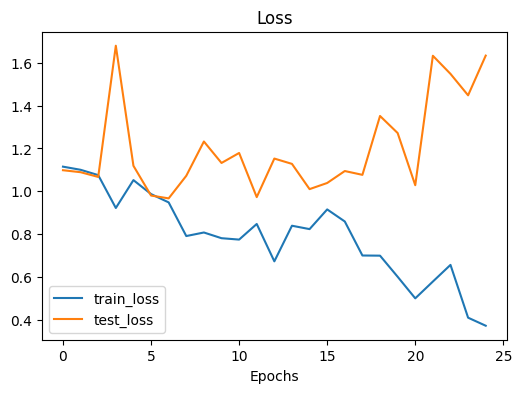

In [455]:
# Plotting the loss curves
plot_loss_curves(results_no_augment)